## Forecast Models

### Imports

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import dates
import mplfinance as mpf
%matplotlib inline
import statsmodels.api as sm
import seaborn as sns

import chart_studio.plotly as py
import plotly.express as px
import plotly.graph_objects as go

import cufflinks as cf # Connects Plotly to Pandas
# Makes Plotly work in your Notebook
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
cf.go_offline()

import requests # Get URL data
from bs4 import BeautifulSoup # Manipulate URL data
import json
from pandas import DataFrame as df

### Seasonal Autoregressive Integrated Moving Average

We were trying to force seasonal data which is why we were getting imperfect results. With SARIMA we use an additional set of parameters that describe seasonal components of our model (P,D,Q)m.

- **P** : Seasonal Regression
- **D** : Differencing
- **Q** : Moving Average
- **m** : Rows in Each Season Cycle 

With monthly data with a yearly seasonal cycle m would equal 12. 


In [779]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose

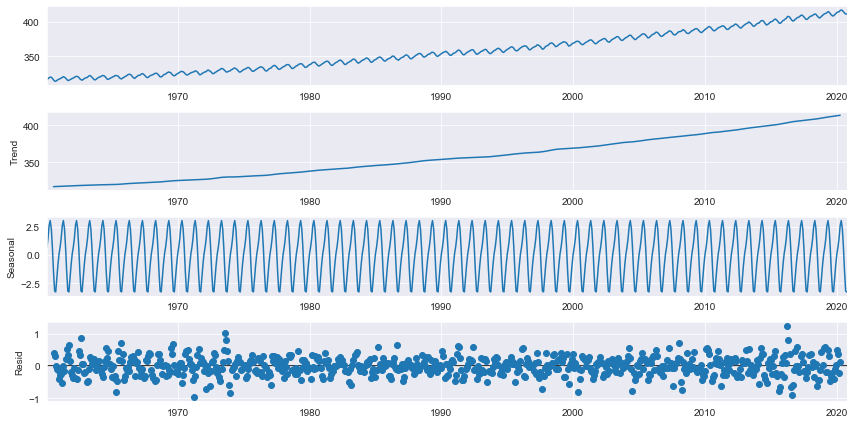

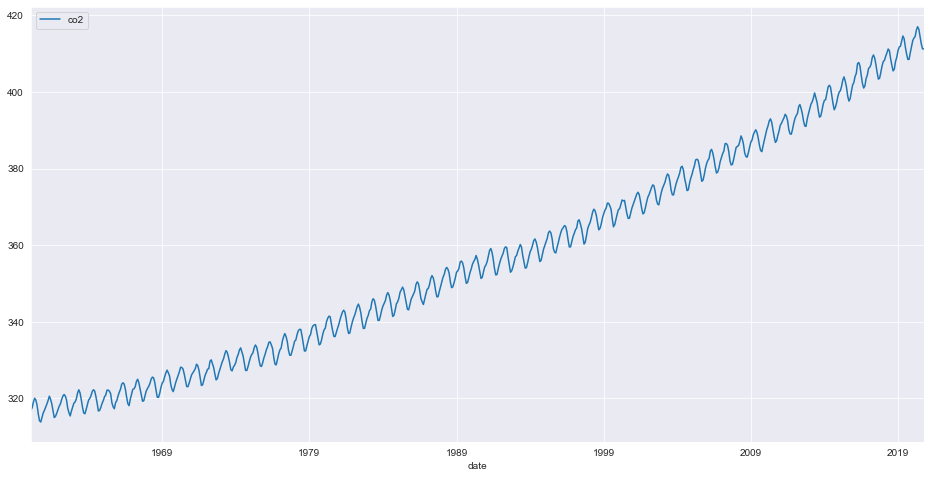

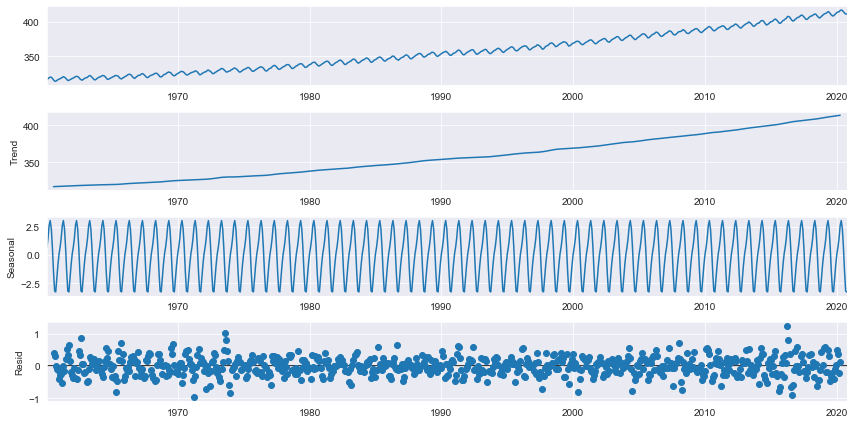

In [794]:
co2_df = pd.read_csv('co2_data.csv', index_col='date', parse_dates=True)

# Monthly global CO2 data since 1960
co2_df = co2_df[co2_df.index>'1960-01-01']
co2_df = co2_df.asfreq('MS') # Change frequency to month
co2_df = co2_df.fillna(method='ffill')
co2_df.plot(figsize=(16,8))

# We verify that there is a seasonal component
res = seasonal_decompose(co2_df, model='add')
res.plot()

In [795]:
# Run auto_arima as seasonal with m since the season occurs 
# over 12 months
auto_arima(co2_df, seasonal=True, m=12, trace=True).summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=461.437, Time=1.03 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2378.581, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.46 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1613.443, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2384.532, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=1102.221, Time=1.43 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=756.768, Time=1.46 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=469.041, Time=3.82 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=489.922, Time=4.22 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=1445.407, Time=0.45 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=inf, Time=3.59 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=587.517, Time=3.85 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=inf, Time=7.97 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=423.290, Time=1.60 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : A

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  729
Model:             SARIMAX(0, 1, 3)x(1, 0, [1], 12)   Log Likelihood                -195.814
Date:                              Mon, 09 Nov 2020   AIC                            403.627
Time:                                      13:44:08   BIC                            431.169
Sample:                                           0   HQIC                           414.255
                                              - 729                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3519      0.036     -9.681      0.000      -0.423      -0.281
ma.L2         -0.0357      0.037     -0.969      0.332      -0.108       0.036
ma.L3         -0.0624      0.034     -1.824      0.068      -0.129       0.005
ar.S.L12       0.9997      0.000   3888.789      0.000       0.999       1.000
ma.S.L12      -0.8642      0.021    -40.218      0.000      -0.906      -0.822
sigma2         0.0928      0.005     20.372      0.000       0.084       0.102
===================================================================================
Ljung-Box (Q):                       42.10   Jarque-Bera (JB):                 3.84
Prob(Q):                              0.38   Prob(JB):                         0.15
Heteroskedasticity (H):               1.19   Skew:                            -0.02
Prob(H) (two-sided):                  0.18   Kurtosis:                         3.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

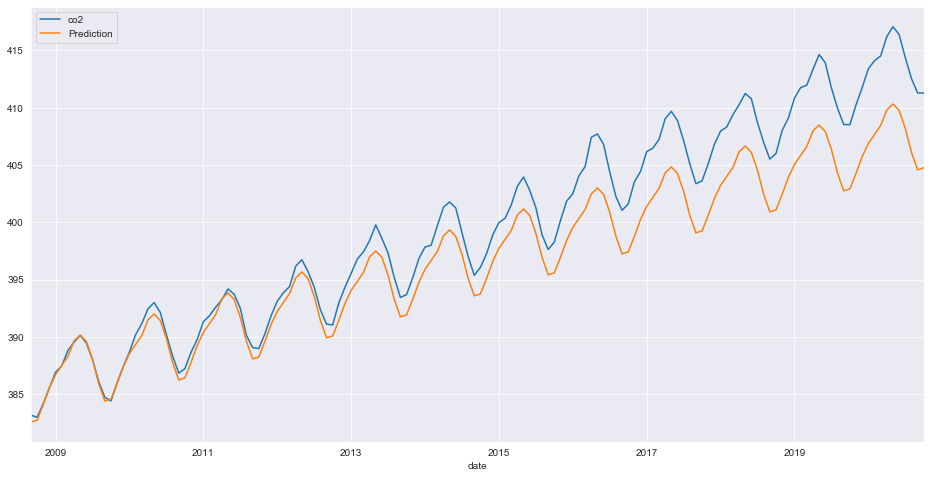

In [807]:
# SARIMAX(0, 1, 3)x(1, 0, [1], 12)

len(co2_df) # 729

train_df = co2_df.iloc[:583] # 80%
test_df = co2_df.iloc[583:] # 20%

# Parameters include the dataset, the 1st order for ARIMA,
# the seasonal order
model = SARIMAX(train_df, order=(0, 1, 3),
               seasonal_order=(1, 0, 1, 12))
res = model.fit()
# Get prediction for test set
start = len(train_df)
end = len(train_df) + len(test_df) - 1
# type typ : levels - Predict original endogenous variables
# linear : Linear prediction
prediction = res.predict(start, end, 
                         typ='linear').rename('Prediction')
test_df.plot(legend=True, figsize=(16,8))
prediction.plot(legend=True)

### Test Prediction

In [808]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# The prediction is pretty good being that the mean is 356.8 
# and the error was 3.43
co2_df.mean() # 356.8
np.sqrt(mean_squared_error(test_df, prediction)) # Off by 3.43


3.430361379720259

### Predict the Future

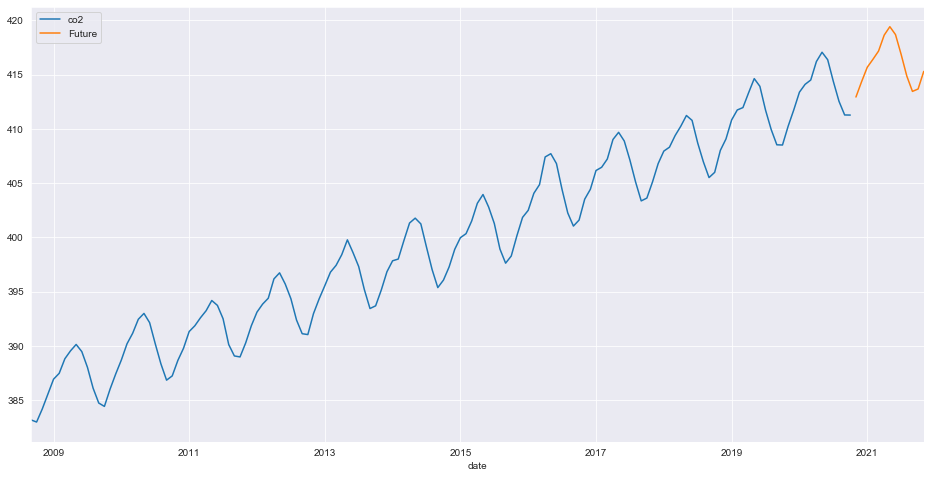

In [806]:
# Predict CO2 levels 1 year into the future
model = SARIMAX(co2_df, order=(0, 1, 3),
               seasonal_order=(1, 0, 1, 12))
res = model.fit()
future = res.predict(len(co2_df), len(co2_df)+12, 
                    typ='levels').rename('Future')
test_df.plot(legend=True, figsize=(16,8))
future.plot(legend=True)

### SARIMAX

SARIMAX supports exogenous regressor variables. Endogenous Variables are dependent on many outside influences. For example the cost of a tomato is based on weather, pests, cost of fuel, etc. 

Exogenous Variables are not effected by outside influences and are fixed in the model. An example of an Exogenous piece of data is used in this video with a holidays effet on the price of oil. A holiday is a unique date, but it happens at exactly the same time, pretty much, every single year.


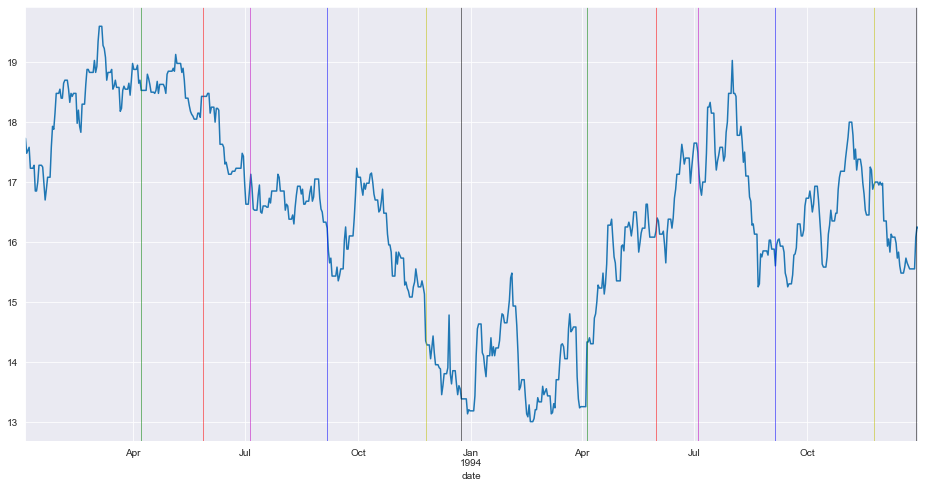

In [860]:
oil_df = pd.read_csv('brent-daily-csv.csv', 
                     index_col='date', parse_dates=True)
# Data up till 1995
oil_df = oil_df[(oil_df.index>'1993-01-01') & (oil_df.index<'1995-01-01')]

oil_df = oil_df.asfreq('D') # Change frequency to day
# Fill missing holiday colun with zeroes
oil_df['holiday'] = oil_df['holiday'].fillna(0)
# Fill price column with what preceeded
oil_df = oil_df.fillna(method='ffill')

# oil_df['price'].plot(figsize=(16,8))

fig, ax = plt.subplots(figsize=(16,8))
ax = oil_df['price'].plot();

# Get index columns where holiday == 1
# Easter(4), Memorial Day(5), Independence Day(7), Labor Day(9), Thanksgiving(11), 
# Christmas(12)
# Easter & Memorial Day and Thanksgiving & Christmas are dark lines
# Draw colored lines every place there is a holiday
color_arr = ['g', 'r', 'm', 'b', 'y', 'k']
c_indx = 0
for x in oil_df[oil_df['holiday']==1].index:
    ax.axvline(x=x, color=color_arr[c_indx], linewidth=0.5);
    if color_arr[c_indx] == 'k':
        c_indx = 0
    else:
        c_indx += 1
    

### Seasonal Component

In [877]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose

# Is there a seasonal component
res = seasonal_decompose(oil_df['price'])
# res.plot();

# Show just the seasonal component
# res.seasonal.plot(figsize=(16,8))

### Auto ARIMA

In [871]:
auto_arima(oil_df['price'], m=7, trace=True).summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=1.26 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=-182.933, Time=0.06 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=-189.475, Time=0.12 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=-191.586, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=-184.864, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=-188.961, Time=0.07 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=-200.746, Time=0.52 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=-190.202, Time=0.12 sec
 ARIMA(0,1,1)(2,0,1)[7] intercept   : AIC=-203.825, Time=0.61 sec
 ARIMA(0,1,1)(2,0,0)[7] intercept   : AIC=-204.213, Time=0.29 sec
 ARIMA(0,1,0)(2,0,0)[7] intercept   : AIC=-199.334, Time=0.20 sec
 ARIMA(1,1,1)(2,0,0)[7] intercept   : AIC=-206.954, Time=0.80 sec
 ARIMA(1,1,1)(1,0,0)[7] intercept   : AIC=-192.707, Time=0.26 sec
 ARIMA(1,1,1)(2,0,1)[7] intercept   : AIC=-206.599, Time=0.95 sec
 ARIMA(1,1,1)(1,0,1)[7] intercept   : 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  726
Model:             SARIMAX(1, 1, 1)x(2, 0, [], 7)   Log Likelihood                 109.426
Date:                            Tue, 10 Nov 2020   AIC                           -208.851
Time:                                    10:39:07   BIC                           -185.920
Sample:                                         0   HQIC                          -200.001
                                            - 726                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5589      0.191     -2.922      0.003      -0.934      -0.184
ma.L1          0.6644      0.178      3.736      0.000       0.316       1.013
ar.S.L7       -0.0854      0.032     -2.670      0.008      -0.148      -0.023
ar.S.L14      -0.1492      0.031     -4.839      0.000      -0.210      -0.089
sigma2         0.0433      0.001     29.856      0.000       0.040       0.046
===================================================================================
Ljung-Box (Q):                       54.71   Jarque-Bera (JB):               356.57
Prob(Q):                              0.06   Prob(JB):                         0.00
Heteroskedasticity (H):               1.67   Skew:                            -0.08
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Make Predictions

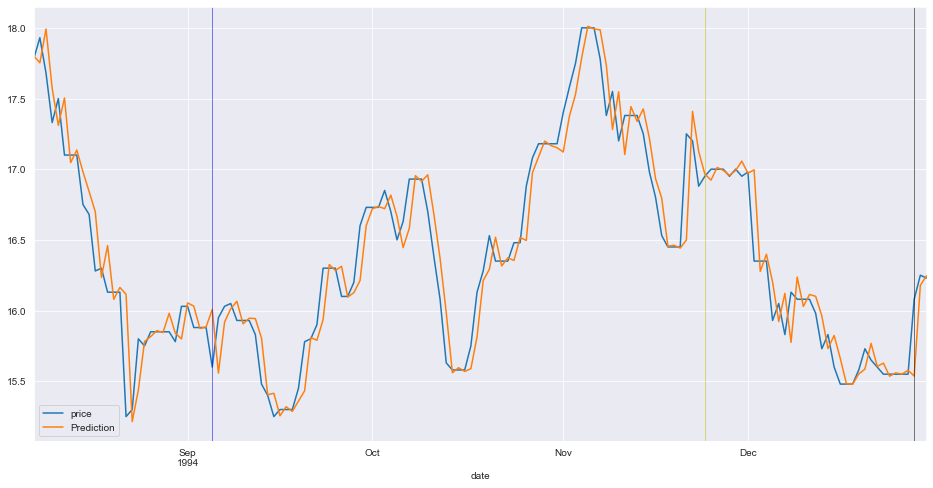

In [876]:
len(oil_df) # 726
train_df = oil_df.iloc[:580] # 80%
test_df = oil_df.iloc[580:]

mod = SARIMAX(oil_df['price'], order=(1,1,1), seasonal_order=(2,0,0,7))
res = mod.fit()
# res.summary()
start = len(train_df)
end = len(train_df) + len(test_df) - 1
prediction = res.predict(start, end).rename('Prediction')
ax = test_df['price'].plot(legend=True, figsize=(16,8))
prediction.plot(legend=True)

# Check if the holiday had any effect on oil prices
color_arr = ['g', 'r', 'm', 'b', 'y', 'k']
c_indx = 0
for x in oil_df[oil_df['holiday']==1].index:
    ax.axvline(x=x, color=color_arr[c_indx], linewidth=0.5);
    if color_arr[c_indx] == 'k':
        c_indx = 0
    else:
        c_indx += 1

### Does Adding Holiday Data Help?

In [880]:
# We must know when holidays will fall into the future because we can't
# predict the future prices and the holidays
# How did we perform and does adding holiday data improve it?
rmse(test_df['price'], prediction)

# Train now with the holiday data
auto_arima(oil_df['price'], exogenous=oil_df[['holiday']], seasonal=True, 
          m=7, trace=True).summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=1.82 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=-180.957, Time=0.14 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=-187.522, Time=0.18 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=-189.639, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=-182.888, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=-186.973, Time=0.10 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=-198.766, Time=0.63 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=-188.247, Time=0.15 sec
 ARIMA(0,1,1)(2,0,1)[7] intercept   : AIC=-201.852, Time=0.70 sec
 ARIMA(0,1,1)(2,0,0)[7] intercept   : AIC=-202.230, Time=0.40 sec
 ARIMA(0,1,0)(2,0,0)[7] intercept   : AIC=-197.340, Time=0.39 sec
 ARIMA(1,1,1)(2,0,0)[7] intercept   : AIC=-204.997, Time=0.78 sec
 ARIMA(1,1,1)(1,0,0)[7] intercept   : AIC=-190.718, Time=0.36 sec
 ARIMA(1,1,1)(2,0,1)[7] intercept   : AIC=-204.661, Time=1.41 sec
 ARIMA(1,1,1)(1,0,1)[7] intercept   : 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  726
Model:             SARIMAX(1, 1, 1)x(2, 0, [], 7)   Log Likelihood                 109.447
Date:                            Tue, 10 Nov 2020   AIC                           -206.894
Time:                                    12:24:14   BIC                           -179.377
Sample:                                01-04-1993   HQIC                          -196.274
                                     - 12-30-1994                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
holiday       -0.0082      0.025     -0.326      0.744      -0.057       0.041
ar.L1         -0.5592      0.191     -2.923      0.003      -0.934      -0.184
ma.L1          0.6649      0.178      3.738      0.000       0.316       1.014
ar.S.L7       -0.0851      0.032     -2.638      0.008      -0.148      -0.022
ar.S.L14      -0.1498      0.031     -4.852      0.000      -0.210      -0.089
sigma2         0.0433      0.001     29.549      0.000       0.040       0.046
===================================================================================
Ljung-Box (Q):                       54.65   Jarque-Bera (JB):               360.97
Prob(Q):                              0.06   Prob(JB):                         0.00
Heteroskedasticity (H):               1.67   Skew:                            -0.08
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

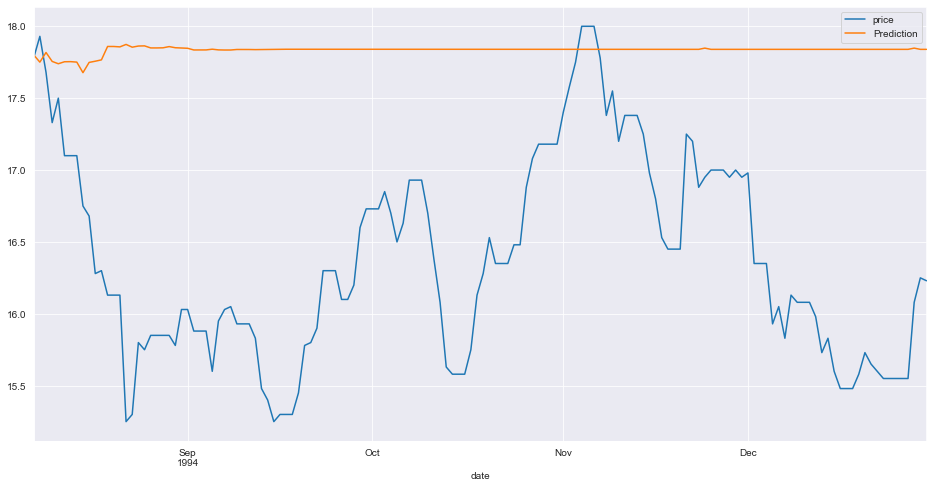

In [884]:
# We can tell it to train and to distort the prediction using holiday data
mod = SARIMAX(train_df['price'], exog=train_df[['holiday']],
             order=(1,1,1), seasonal_order=(2,0,0,7))
res = mod.fit()
start = len(train_df)
end = len(train_df) + len(test_df) - 1
prediction = res.predict(start, end, exog=test_df[['holiday']]).rename('Prediction')

# As you can see from the plot that holiday has nothing to do with the price of oil
ax = test_df['price'].plot(legend=True, figsize=(16,8))
prediction.plot(legend=True)